### Notebook used to to measure collimation of the telescope using ATCollCam using the CWFS algorithm/package developed by Bo Xin.

#### https://github.com/bxin/cwfs.git

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. It also requires functions I've written that are from my personal repo (https://github.com/patrickingraham/lsst_python_utils.git)

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]


import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import copy
from pathlib import Path

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')


In [2]:
#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [3]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [4]:
# This is just used to test the CofM algorithm.

def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

2019-09-10 03:56:36,010 calc_CofM_logger INFO     y_CofM is 700.0
2019-09-10 03:56:36,012 calc_CofM_logger INFO     x_CofM is 350.0


(700.0, 350.0)

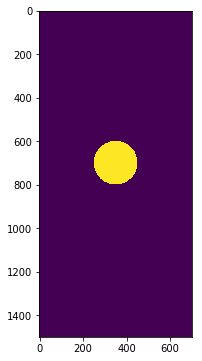

In [5]:
# Testing the CofM code
stamp=make_circle((1500,700), 100, center=(700,350))
fig, ax = plt.subplots(figsize=(7,6))
ax.imshow(stamp, interpolation='none')
stamp.shape

calc_CofM(stamp)

In [6]:
# Declare where data is located and where output will be written, notably the stacked doughnuts
data_folder = Path("/home/saluser/data/20190907")
output_folder = Path("/home/saluser/data/output")

# Extrafocal raw image list from a manually made txt file
file_to_open = data_folder / "extra_focal_list2.txt"
tmp=file_to_open.read_text()
extra_focal_fnames=tmp.split('\n')
for i,f in enumerate(extra_focal_fnames):
    extra_focal_fnames[i]+='.fits'
# remove last line as it has just .fits
extra_focal_fnames.remove(extra_focal_fnames[-1])

In [7]:
# Intrafocal raw image list from a manually made txt file
file_to_open = data_folder / "intra_focal_list.txt"
tmp=file_to_open.read_text()
intra_focal_fnames=tmp.split('\n')
for i,f in enumerate(intra_focal_fnames):
    intra_focal_fnames[i]+='.fits'
# remove last line as it has just .fits
intra_focal_fnames.remove(intra_focal_fnames[-1])

In [8]:
#extra_focal_fnames

In [9]:
# Function to rebin the arrays, not used at the moment but may be
# Example is: 
# binsize=8
#d_binned = rebin(d, [int(d.shape[0]/bin_size), int(d.shape[1]/bin_size)])

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Loop over stack of images, centering to account for jitter then adding to create long-exposure doughnut

In [10]:
# Select if you want to make intra or extra-focal image
intra=True
if intra == True:
    focal_fnames = intra_focal_fnames
else:
    focal_fnames = extra_focal_fnames


# declare size of image array
img_size=(3520, 4656) # y,x

# Declare center of first image (guess)
center_of_ref=(900, 3180)
logger.info('Center of image 0 is set as: {}'.format(center_of_ref))

# Declare sub-array size for centroiding
side=None
side=300
#Declare array for final doughnut
focal_doughnut = None
focal_doughnut = np.empty((2*side, 2*side), dtype=float)

#reset a bunch of variables because I don't see where the memory issue is.
d=None; d0=None; d1=None

#Loop over all files in list
for i,fname in enumerate(focal_fnames):
    
    with fits.open(data_folder / fname) as hdul0:
        logger.info("Processing file {}".format(fname))
        # data is [y,x]

        #For testing
        #circle = make_circle(img_size, radius=20, center=(900,3080))
        #print('shape of circle: {}'.format(circle.shape))
        
        d0=None        
        raw_frame = None
        #raw_frame = circle
        raw_frame = hdul0[0].data
        
        # Create subimage
        d0=np.array((raw_frame[center_of_ref[0]-side:center_of_ref[0]+side, 
                        center_of_ref[1]-side:center_of_ref[1]+side]))
        
        #convert to float
        d0=copy.deepcopy(d0.astype(float))
        logger.debug('shape of d0: {}'.format(d0.shape))

        # subtract median background... which should do nothing to the centroid
        #d1= d0- np.median(d0)
        #d1 = copy.deepcopy(d0)
        #d_full=hdul0[0].data
        
        #boxcar smooth to remove hot pixels
        d = None
        #d = ndimage.median_filter(d1, size=15)
        d = copy.deepcopy(d0)
        
        # Measure centroid (CofM)
        #corner=np.array(center_of_ref)-side
        #d_CofM = calc_CofM(d, corner) # y,x is 3179,923 (add y=20 gives 3160,923)
        #print('Corner coor d_CofM {}'.format(d_CofM))
        
        #now without the reference
        d_CofM=None
        d_CofM = np.array(calc_CofM(d)) # y,x is 3179,923 (add y=20 gives 3160,923)
        logger.debug('No corner correction d_CofM as calculated {}'.format(d_CofM))
    
        yoffset_to_center_of_ref = (d_CofM[0]-side)
        xoffset_to_center_of_ref = (d_CofM[1]-side)
        logger.debug('yoffset: {}'.format(yoffset_to_center_of_ref))
        logger.debug('xoffset: {}'.format(xoffset_to_center_of_ref))
        
        new_center = None
        new_center = np.array((center_of_ref[0]+yoffset_to_center_of_ref,
                     center_of_ref[1]+xoffset_to_center_of_ref), dtype=int)
        
        logger.debug('new center is: {}'.format(new_center))
        
        # Create new stamp at CofM
        stamp=None
        stamp=np.array((raw_frame[new_center[0]-side:new_center[0]+side, 
                        new_center[1]-side:new_center[1]+side]))
        
        # Add it to the stack of doughnuts
        focal_doughnut0=copy.deepcopy(focal_doughnut)
        focal_doughnut+=stamp

        # Take the new center and use it as first guess at
        # position for next image
        center_of_ref = copy.deepcopy(new_center)
        
        # Display Imagefor troubleshooting (or finding first center)
        if i >= 6 and False: #7 is problematic
            mag=1
            print('Displaying image {}'.format(fname))
            #plt.rcParams['figure.figsize'] = [7*mag, 6*mag]
            #plt.imshow(d)
            
            fig, ax = plt.subplots(figsize=(7,6))

            ax.imshow(d, interpolation='none')#, extent=[center_of_ref[1]+side,
                                              #       center_of_ref[1]-side, 
                                              #       center_of_ref[0]+side,
                                              #       center_of_ref[0]-side])
            
            fig2, ax2 = plt.subplots(figsize=(7,6))
            ax2.imshow(stamp, interpolation='none')
            
            fig3, ax3 = plt.subplots(figsize=(7,6))
            ax3.imshow(focal_doughnut, interpolation='none')
            
            # show full frame
            #fig, ax = plt.subplots(figsize=(7,6))
            #ax.imshow(d_full, interpolation='none')
            
            break

2019-09-10 03:56:42,635 calc_CofM_logger INFO     Center of image 0 is set as: (900, 3180)
2019-09-10 03:56:42,644 calc_CofM_logger INFO     Processing file 1325681406-AlfPsA_intra-0-10.fits
2019-09-10 03:56:42,750 calc_CofM_logger INFO     y_CofM is 213.26798941899952
2019-09-10 03:56:42,751 calc_CofM_logger INFO     x_CofM is 485.48884722538855
2019-09-10 03:56:42,759 calc_CofM_logger INFO     Processing file 1325681406-AlfPsA_intra-1-10.fits
2019-09-10 03:56:42,885 calc_CofM_logger INFO     y_CofM is 284.3173021451823
2019-09-10 03:56:42,886 calc_CofM_logger INFO     x_CofM is 343.77151837532
2019-09-10 03:56:42,893 calc_CofM_logger INFO     Processing file 1325681407-AlfPsA_intra-2-10.fits
2019-09-10 03:56:42,973 calc_CofM_logger INFO     y_CofM is 142.37347186219426
2019-09-10 03:56:42,974 calc_CofM_logger INFO     x_CofM is 438.82294452496717
2019-09-10 03:56:42,980 calc_CofM_logger INFO     Processing file 1325681408-AlfPsA_intra-3-10.fits
2019-09-10 03:56:43,057 calc_CofM_logge

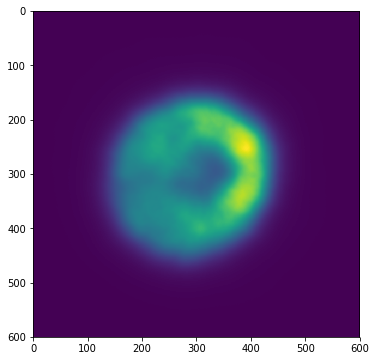

In [12]:
# Show final stacked doughnut
fig4, ax4 = plt.subplots(figsize=(7,6))
ax4.imshow(focal_doughnut, interpolation='none')

In [12]:
#Write fits files (if you want)
if False:
    hdu=None
    hdu = fits.PrimaryHDU(focal_doughnut)
    hdul = fits.HDUList([hdu])
    if intra == True:
        intra_fname='I1_intra_20190908.fits'
        print('writing intra file {}'.format(intra_fname))
        hdul.writeto(output_folder / intra_fname, overwrite=False)
    else:
        extra_fname='I2_extra_20190908.fits'
        print('writing extra file {}'.format(extra_fname))
        hdul.writeto(output_folder / extra_fname, overwrite=False)

In [13]:
# Open fits files, note you can start here if your files exist already
intra_exp = None; extra_exp = None

intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(output_folder / intra_fname))[0].data
extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(output_folder / extra_fname))[0].data

In [14]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]
#I_focus = Image(isr_corr_exposure_focus.subset(bbox_focus).image.array, fieldXY, Image.EXTRA)
I1 = None; I2=None
I1 = Image(intra_exp, fieldXY, Image.INTRA)
I2 = Image(extra_exp, fieldXY, Image.EXTRA)

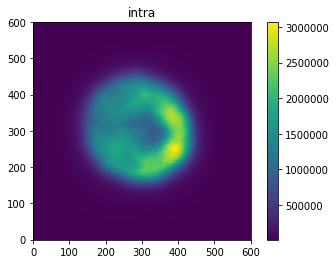

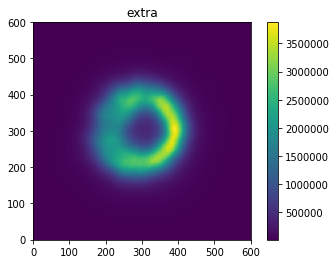

In [15]:
# Plot images
plots.plotImage(I1.image,'intra')
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [16]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example

In [17]:
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example

In [18]:
# Calculate zernikes and wavefront
algo.runIt(inst,I1,I2,'onAxis')

In [19]:
#print zernikes
print(algo.zer4UpNm)

[-27.95024947  66.6761113  -28.23338795 -25.0049208   61.09003889
  15.08907855 -21.42344217 -17.59152802   1.3727474    1.13585329
  -8.14749292  -2.70051112  -0.57350897   3.71869361   1.68413346
  -0.31447373   1.60049417   8.521996     3.93760888]


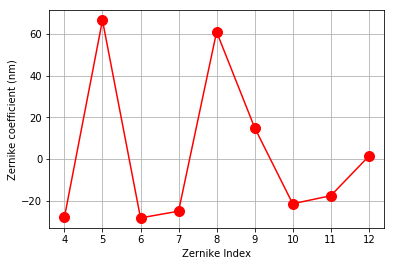

In [20]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

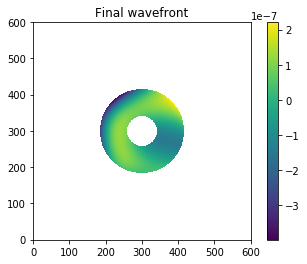

In [21]:
plots.plotImage(algo.Wconverge,'Final wavefront')

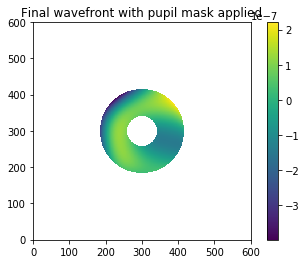

In [22]:
plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

In [ ]:
# Basic math to estimate the expected result (from lab setup)
D=25e-3; wave=632e-9
f_coll=125e-3; 

f_tel=400e-3 # 400mm nominal
pinhole_diam=10e-6

print('Diffraction Limit (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(1e6*wave/D*f_coll))
mag=f_tel/f_coll
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/10))